In [161]:
import pandas as pd
import numpy as np
import jsonl_to_dfs
import trollcleanup
import nlprocess
import plot
import russian_models
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Detecting Tweets from Russian Troll Accounts

## Objective
The objective of this project is to detect whether a tweet was sent from an account tied to Russia's Internet Research Agency based purely on its text content. The scope of the project is looking at tweets specifically sent during the highest activity of these accounts discovered by the House Intelligence Committee investigation, identified in the dataset reconstructed by NBC News and available at https://www.kaggle.com/vikasg/russian-troll-tweets. These messages were compared against tweets collected on Harvard's Dataverse for the 2016 Presidential election at https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PDI7IN. Samples were taken from the 'Candidates and key election hashtags' collection and their content was compared to that from the Kaggle set in order to verify that their topics were similar to justify comparison. The time frame was narrowed to those in common between the two sets.

## Data Cleaning
The data is gathered into separate Pandas DataFrames which are then cleaned before merging them together into our final corpus. The documents in both sets contain text that is in multiple languages. For this project we have narrowed our scope to looking purely at the tweets in English. User information for the Troll accounts is fairly limited and so it is likely that English tweets sent from accounts with missing information may have been dropped from the corpus unnecessarily. Future steps would include recovering these samples using language detection.

In [2]:
tweets,users = jsonl_to_dfs.get_all_df(["tweets1.jsonl","tweets2.jsonl","tweets3.jsonl"])

In [176]:
nontroll=trollcleanup.clean_tweets_df(tweets,0)

Original: 411422
Drop null ids: 411422
Drop null tweets: 411422
411422
411421
Drop dup tweet ids: 411421
All languages: 411421
Just English: 379198


In [177]:
nontroll.head()

,created_str,hashtags,text,lang,retweeted,mentions,hashtags_count,mentions_count,date_time,target
763431308773040128,Wed Aug 10 17:46:22 +0000 2016,[teaparty],Emails show staffers approving a deal that l...,en,1,"[TPPatriots, HillaryClinton]",1,2,2016-08-10 17:46:22,0
763431353111027712,Wed Aug 10 17:46:33 +0000 2016,[],"Why are the media, politicians and big busine...",en,1,[ThankYouDonald],0,1,2016-08-10 17:46:33,0
763431388984975360,Wed Aug 10 17:46:41 +0000 2016,[],Guy behind Trump immediately realized what he...,en,1,[ChrisVannini],0,1,2016-08-10 17:46:41,0
763431441535467520,Wed Aug 10 17:46:54 +0000 2016,[],"you should care, it shows hes in with mob, p...",en,0,[cull0519],0,1,2016-08-10 17:46:54,0
763431528382758912,Wed Aug 10 17:47:14 +0000 2016,[hillarykilledmyfriends],No way! She’s the beacon of integrity. And peo...,en,0,[],1,0,2016-08-10 17:47:14,0


In [178]:
troll=pd.read_csv('russian-troll-tweets/tweets.csv')
troll.head()

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,1.868981e+09,ryanmaxwell_1,1.458672e+12,2016-03-22 18:31:42,NaN,NaN,NaN,#IslamKills Are you trying to say that there w...,7.123460e+17,NaN,"[""IslamKills""]",[],POSTED,[],NaN,NaN
1,2.571870e+09,detroitdailynew,1.476133e+12,2016-10-10 20:57:00,0.0,False,0.0,"Clinton: Trump should’ve apologized more, atta...",7.855849e+17,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],"[""http://detne.ws/2e172jF""]",POSTED,[],NaN,NaN
2,1.710805e+09,cookncooks,1.487767e+12,2017-02-22 12:43:43,NaN,NaN,NaN,RT @ltapoll: Who was/is the best president of ...,8.343832e+17,NaN,[],[],POSTED,[],NaN,NaN
3,2.584153e+09,queenofthewo,1.482765e+12,2016-12-26 15:06:41,NaN,NaN,NaN,RT @jww372: I don't have to guess your religio...,8.134006e+17,NaN,"[""ChristmasAftermath""]",[],POSTED,[],NaN,NaN
4,1.768260e+09,mrclydepratt,1.501987e+12,2017-08-06 02:36:24,NaN,NaN,NaN,RT @Shareblue: Pence and his lawyers decided w...,8.940243e+17,NaN,[],[],POSTED,[],NaN,NaN


In [37]:
t_users = pd.read_csv('russian-troll-tweets/users.csv')
t_users.head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
0,18710816.0,near Utah Ave & Lighthouse an,Robby Delaware,304.0,11484.0,Pacific Time (US & Canada),False,en,RobbyDelaware,"I support the free movement of people, ideas a...",Wed Jan 07 04:38:02 +0000 2009,17.0,670.0,13.0
1,100345056.0,still ⬆️Block⤵️Corner⬇️street,#Ezekiel2517✨...,1053.0,31858.0,NaN,False,en,SCOTTGOHARD,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,Tue Dec 29 23:15:22 +0000 2009,2774.0,1055.0,35.0
2,247165706.0,"Chicago, IL",B E C K S T E R✨,650.0,6742.0,Mountain Time (US & Canada),False,en,Beckster319,Rebecca Lynn Hirschfeld Actress.Model.Writer.A...,Fri Feb 04 06:38:45 +0000 2011,7273.0,896.0,30.0
3,249538861.0,NaN,Chris Osborne,44.0,843.0,NaN,False,en,skatewake1994,NaN,Wed Feb 09 07:38:44 +0000 2011,227.0,154.0,1.0
4,449689677.0,NaN,Рамзан Кадыров,94773.0,10877.0,Moscow,False,ru,KadirovRussia,"Пародийный аккаунт. Озвучиваю то, что политика...",Thu Dec 29 11:31:09 +0000 2011,0.0,7.0,691.0


In [179]:
troll=trollcleanup.clean_tweets_df(troll,1,t_users)

Original: 203482
Drop null ids: 201168
Drop null tweets: 201147
201147
200640
Drop dup tweet ids: 200640


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


All languages: 200640
Just English: 37952


In [180]:
troll.head()

,created_str,retweeted,text,hashtags,mentions,hashtags_count,mentions_count,date_time,lang,target
3,2016-12-26 15:06:41,1,I don't have to guess your religion!,[ChristmasAftermath],[],1,0,2016-12-26 15:06:41,en,1
4,2017-08-06 02:36:24,1,Pence and his lawyers decided which of his of...,[],[],0,0,2017-08-06 02:36:24,en,1
17,2017-01-11 10:36:18,1,". Scores FIRST Hot 100 Hit With ""Bad And Bou...",[1],[],1,0,2017-01-11 10:36:18,en,1
19,2017-02-09 10:26:17,1,The Marco Rubio knockdown of Elizabeth Warren...,[],[],0,0,2017-02-09 10:26:17,en,1
30,2017-02-28 05:43:25,1,"This week's ""Sweden incident.""",[],[],0,0,2017-02-28 05:43:25,en,1


In [182]:
troll,nontroll = trollcleanup.filter_time(troll,nontroll)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Exploratory Data Analysis
Initial exploration of the data is performed to verify our assumption that the topics between the two datasets are comparable for the training of our model and to gain insight into our corpus.

### Top Hashtags in Each Class

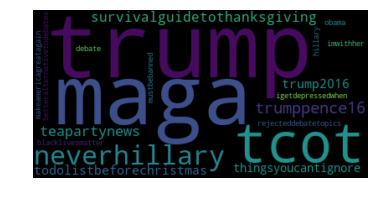

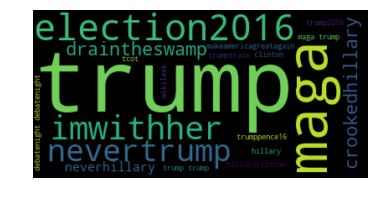

In [85]:
troll_tags = troll['hashtags']
nontroll_tags = nontroll['hashtags']

nlprocess.create_wordcloud(troll_tags,20)
nlprocess.create_wordcloud(nontroll_tags,20)

### Top Words in Each Class

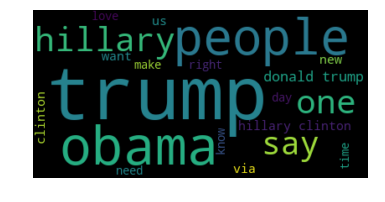

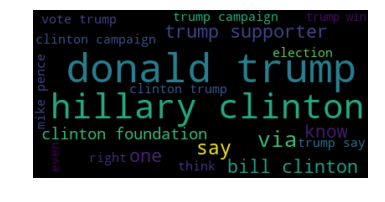

In [86]:
troll_vocab = troll['text']
nontroll_vocab = nontroll['text']

nlprocess.create_wordcloud(troll_vocab,20)
nlprocess.create_wordcloud(nontroll_vocab,20)

### EDA Conclusions
Visualization of the most common words and hashtags in our two datasets indicates that though there are some differences between them that they are likely to be focused around the same topics of discussion. Having verified our assumption we move on now to creating our corpus and building our models.

In [188]:
df = pd.concat([troll,nontroll]).drop(columns=['mentions','hashtags','created_str','lang'],axis=1)
df.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,hashtags_count,mentions_count,retweeted,target,text
47,2,2,1,1,Tried to tell the staff this today.
65,0,0,0,1,Clinton’s VP Choice: More Harm Than Good
74,1,1,1,1,After Hillary Clinton Caught 4attempting 2tak...
78,0,0,1,1,to be my best friend. \r\nI hate all my frie...
85,0,1,1,1,"""The arrogance of Washington DC will soon com..."


## Natural Language Processing

In exploring our models we tried various treatments of the corpus including: removal of stopwords, lemmatization, term frequency-inverse document frequency (TFIDF) transformation, and inclusion of bi-grams. Based on the impact on our model's performance we removed stopwords and used TFIDF but did not keep the other treatments.

In [198]:
text = df[['text']]
target = df['target']

In [210]:
vectorizer,text_transformer=nlprocess.text_process(text,True)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Model Considerations
- ### Chosen Features
The features chosen for our model include the processed, tokenized text as well as values engineered from the text: the number of hashtags, number of mentions and whether the tweet was a retweet or not. 
- ### Class Imbalance
Tweets labeled as coming from Troll users account for only ~10% of our data and so certain considerations were taken to address this imbalance. Random undersampling and oversampling were both tried when testing our baseline models. Oversampling in general led to higher performance but was more resource intensive and so for ease of iteration the following models were built using random undersampling.
- ### Model Plan
Due to performance restrictions of our kernels it was necessary to split the text and nontext data into separate DataFrames. Separate models were then built for each set of features and then stacked together using max confidence between the two models' outputs. 

## Train Test Split
In order to stack our models together special consideration was taken to ensure the samples were split and undersampled identically.

In [199]:
X_train,X_test,y_train,y_test = nlprocess.data_sampler(df.drop(columns=['target'],axis=1),target)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [255]:
# Engineered features
feat_train=X_train[:,:-1]
feat_test=X_test.drop(columns=['text'],axis=1)

In [211]:
# Text features
text_train=text_transformer.transform(vectorizer.transform(X_train[:,-1]))
text_test=text_transformer.transform(vectorizer.transform(X_test['text']))

In [212]:
# Combined sets for engineered features and text features for later evaluation
feat_split=[feat_train,feat_test,y_train,y_test]
text_split=[text_train,text_test,y_train,y_test]

## Baseline Models
The following models were considered:
* Random Forest
* SGDClassifier
* Naive Bayes
* Logistic Regression

In [213]:
rf=RandomForestClassifier(random_state=19)
sgd=SGDClassifier(random_state=19)
nb=MultinomialNB()
lr=LogisticRegression()
models=[
    rf,sgd,nb,lr
]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=19, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.75      0.85     94800
           1       0.09      0.66      0.16      3710

   micro avg       0.75      0.75      0.75     98510
   macro avg       0.54      0.70      0.51     98510
weighted avg       0.95      0.75      0.82     98510



Normalized confusion matrix
[[0.74952532 0.25047468]
 [0.34097035 0.65902965]]


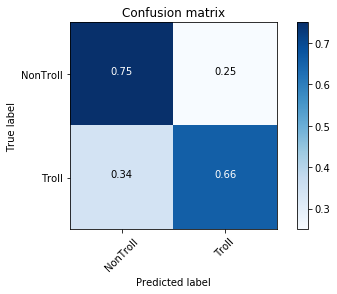

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=19, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     94800
           1       0.11      0.46      0.17      3710

   micro avg       0.83      0.83      0.83     98510
   macro avg       0.54      0.66      0.54     98510
weighted avg       0.94      0.83      0.88     98510



Normalized confusion matrix
[[0.84739451 0.15260549]
 [0.5361186  0.4638814 ]]


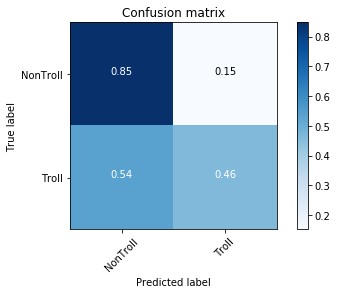

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
              precision    recall  f1-score   support

           0       0.97      0.81      0.88     94800
           1       0.09      0.47      0.15      3710

   micro avg       0.80      0.80      0.80     98510
   macro avg       0.53      0.64      0.52     98510
weighted avg       0.94      0.80      0.86     98510



Normalized confusion matrix
[[0.80862869 0.19137131]
 [0.53018868 0.46981132]]


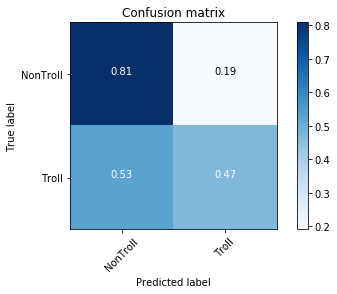

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.42      0.59     94800
           1       0.05      0.75      0.09      3710

   micro avg       0.43      0.43      0.43     98510
   macro avg       0.51      0.59      0.34     98510
weighted avg       0.94      0.43      0.57     98510



Normalized confusion matrix
[[0.42220464 0.57779536]
 [0.24797844 0.75202156]]


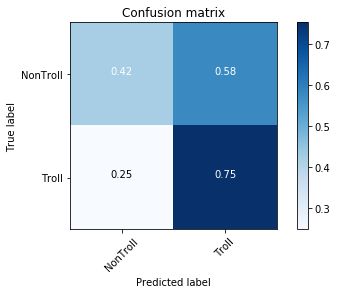

In [256]:
russian_models.strut_models(models,feat_split)

### Performance: Engineered Feature models
Based on Troll recall and precision we chose the SGDClassifer to use for our engineered features.

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=19, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     94800
           1       0.10      0.66      0.17      3710

   micro avg       0.76      0.76      0.76     98510
   macro avg       0.54      0.71      0.51     98510
weighted avg       0.95      0.76      0.83     98510



Normalized confusion matrix
[[0.75984177 0.24015823]
 [0.3393531  0.6606469 ]]


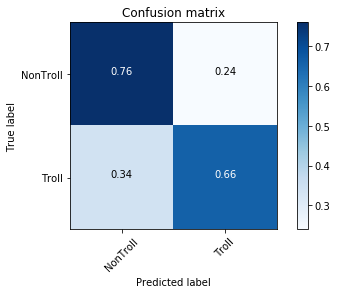

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=19, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.71      0.83     94800
           1       0.09      0.70      0.16      3710

   micro avg       0.71      0.71      0.71     98510
   macro avg       0.54      0.71      0.49     98510
weighted avg       0.95      0.71      0.80     98510



Normalized confusion matrix
[[0.71314346 0.28685654]
 [0.29892183 0.70107817]]


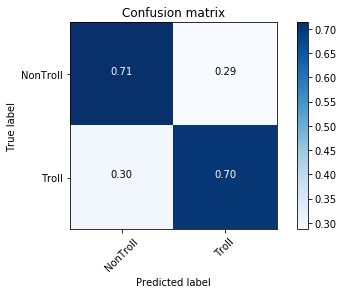

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     94800
           1       0.08      0.47      0.14      3710

   micro avg       0.79      0.79      0.79     98510
   macro avg       0.53      0.64      0.51     98510
weighted avg       0.94      0.79      0.85     98510



Normalized confusion matrix
[[0.79958861 0.20041139]
 [0.52695418 0.47304582]]


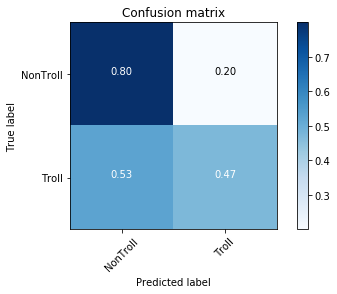

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     94800
           1       0.08      0.72      0.15      3710

   micro avg       0.68      0.68      0.68     98510
   macro avg       0.53      0.70      0.47     98510
weighted avg       0.95      0.68      0.78     98510



Normalized confusion matrix
[[0.67909283 0.32090717]
 [0.27978437 0.72021563]]


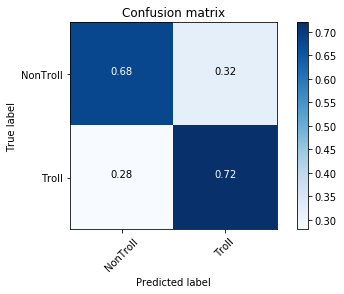

In [257]:
russian_models.strut_models(models,text_split)

### Performance: Text Feature models
Based on Troll recall, precision and training speed we chose the SGDClassifer to use for our text features.

## Gridsearched Models

The following parameters were found to be optimal for both of our models after performing separate Grid Searches.

```
'alpha': 0.0001,
'eta0': 0.0001,
'learning_rate': 'optimal',
'loss': 'modified_huber',
'max_iter': 5,
'penalty': 'l1',
'random_state': 19
```

### Final Individual Models

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0001, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
       max_iter=5, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=19, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     94800
           1       0.12      0.27      0.17      3710

   micro avg       0.90      0.90      0.90     98510
   macro avg       0.55      0.60      0.56     98510
weighted avg       0.94      0.90      0.92     98510



Normalized confusion matrix
[[0.92558017 0.07441983]
 [0.73315364 0.26684636]]


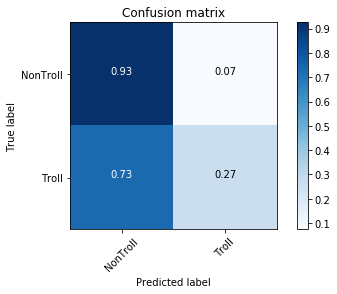

In [260]:
sgd_feat=SGDClassifier(alpha=.0001,eta0=.0001,learning_rate='optimal',loss='modified_huber',max_iter=5,penalty='l1',random_state=19)
foot_model, foot_prob = russian_models.strut_models([sgd_feat],feat_split,True)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
       max_iter=5, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=19, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
              precision    recall  f1-score   support

           0       0.98      0.67      0.79     94800
           1       0.07      0.67      0.13      3710

   micro avg       0.67      0.67      0.67     98510
   macro avg       0.53      0.67      0.46     98510
weighted avg       0.95      0.67      0.77     98510



Normalized confusion matrix
[[0.66623418 0.33376582]
 [0.32884097 0.67115903]]


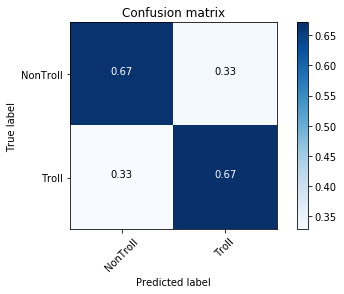

In [261]:
sgd_text=SGDClassifier(alpha=.0001,loss='modified_huber',max_iter=5,penalty='l1',random_state=19)
text_model, text_prob=russian_models.strut_models([sgd_text],text_split,True)

### Model Stack
The above individual models were combined using Max Confidence with weighted votes. Below are the results for weighting the engineered feature model greater and then lesser, respectively.

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/flatironschool/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Combined Votes:
Normalized confusion matrix
[[0.91941983 0.08058017]
 [0.60377358 0.39622642]]


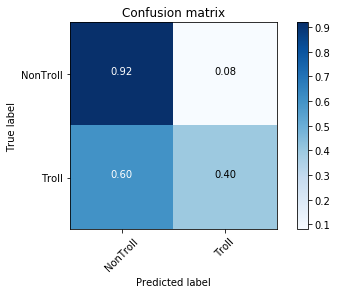

In [262]:
russian_models.predict(russian_models.pred_max,foot_model.predict_proba(feat_test),text_model.predict_proba(text_test),y_test,weight=2)

Combined Votes:
Normalized confusion matrix
[[0.83657173 0.16342827]
 [0.42938005 0.57061995]]


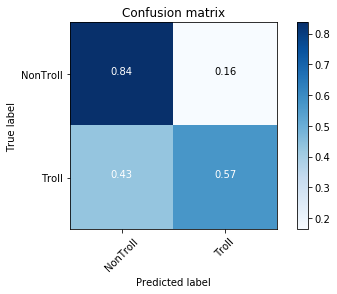

In [263]:
russian_models.predict(russian_models.pred_max,foot_model.predict_proba(feat_test),text_model.predict_proba(text_test),y_test,weight=.5)

### Model Stack Performance

AUC: 0.7725402208650358


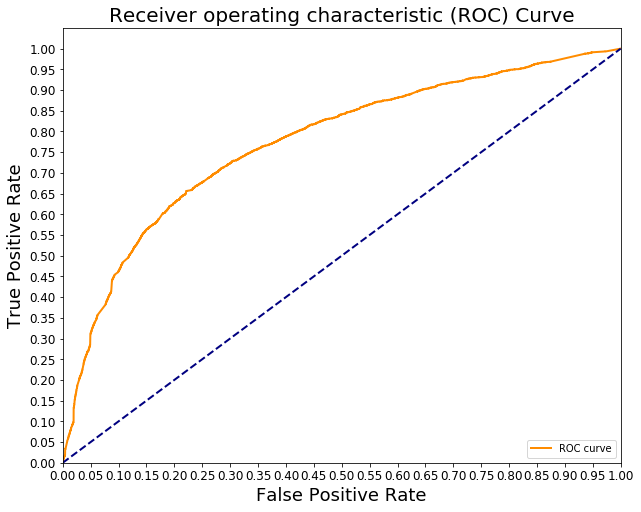

In [245]:
y_score = russian_models.decision_func(foot_model.predict_proba(feat_test),text_model.predict_proba(text_test))
plot.plot_roc(y_test,y_score)

## Conclusions
The Engineered Feature model's performance was found to have good recall on the non troll tweets. The Text Feature model's performance was found to have good recall on the troll tweets. In stacking the models together using Max Confidence we leverage the strengths of each individual model to better classify unseen tweets. By varying the weight we can also adjust the model to be more or less sensitive to Troll tweets depending on our acceptable level of False Positives which in context would be falsing flagging real user tweets.

Our final model created by stacking two separate Stochastic Gradient Descent Classifiers managed to identify 49-57% of Troll tweets while falsely flagging about 12-16% of regular tweets, depending on the chosen weight parameter. The AUC for the final model reached .77 for the unweighted case which was impressive given the few features fed into the model. Next steps for the project would include further analysis and treatment of the hashtags and mentions contained in the tweets as well as using more advanced Natural Language Processing tools like sentiment analysis and language detection. Based on our exploration in dealing with the class imbalance further improvements in the performance of the model are likely with oversampling instead of undersampling.